In [129]:
# set the option to display the full string from a pandas DataFrame
#pd.options.display.max_rows
#pd.set_option('display.max_colwidth', -1)

## Gather

In [130]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import requests
import os
import json
import glob
from timeit import default_timer as timer

In [131]:
# read in the archive information from we rate dogs
# this includes the tweet IDs and other basic info but not responses such as likes and views
df_1 = pd.read_csv('twitter_archive_enhanced.csv')
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [132]:
#import pandas as pd
#import os
#import requests
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response
with open(os.path.join(folder_name,
                      url.split('/')[-1]), mode='wb') as file:
    image_predictions = file.write(response.content)
#df_2 = pd.read_csv('image-predictions.tsv', sep = '\t')
#df_2.head()

In [142]:
df_2 = pd.read_csv('image_predictions/image-predictions.tsv', sep = '\t')
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Create Third Dataframe

In [134]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [135]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

#### The following cell contains code to query Twitter's API, read the data in, and save the data to a csv.  I am submitting the csv with the project, because this code takes more than 20 minutes to run and only really needs to be run one time.

#### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
 #Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + " " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [155]:
folder_name = 'json'
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
url = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)
response
with open(os.path.join(folder_name,
                      url.split('/')[-1]), mode='wb') as file:
    tweet_json = file.write(response.content)

## First attempt at creating a dataframe with tweet_json.txt

In [157]:
data = []
with open ('json/tweet-json.txt', 'r') as json_file:
    for line in json_file:
        data.append(json.loads(line))

In [158]:
df_3 = pd.DataFrame(data)

In [159]:
df_3.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Second attempt at creating a dataframe with tweet_json.txt

In [164]:
# read in tweet_JSON.txt line by line into a pandas dataframe
# import json
with open('json/tweet-json.txt') as json_file:
    data = json.load(json_file)

JSONDecodeError: Extra data: line 2 column 1 (char 3974)

In [161]:
with open('tweet_json.txt') as json_file:
    data = json.load(json_file)
    for j in data:
        print('tweet id: ' + j['tweet_id'])
        print('retweet count: ' + j['retweet_count'])
        print ('favorite count: ' + j['favorite_count'])
        print('')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [162]:
```
for p in data['people']
```

SyntaxError: invalid syntax (<ipython-input-162-8ffb26d98fa3>, line 1)

## Third attempt at creating a dataframe with tweet_json.txt

In [165]:
# create list called 'data', then load json file and store it in the list 
data = []
with open('json/tweet-json.txt') as json_file:
    for line in json_file:
        data.append(json.loads(line))

In [166]:
# create dataframe
df_3 = pd.DataFrame(data)

In [167]:
df_3.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [168]:
# append required columns to the dataframe
required_columns = ['id', 'retweet_count', 'favorite_count']
df_3 = df_3[required_columns]

In [169]:
df_3.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assess

In [9]:
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
df_1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [11]:
df_1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
df_1.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [13]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
sum(df_1.duplicated())

0

In [16]:
sum(df_1['tweet_id'].duplicated())

0

In [17]:
df_1[df_1['tweet_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [18]:
list(df_1)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [19]:
df_1.sample(6)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1194,717428917016076293,NaN,NaN,2016-04-05 19:09:17 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Skittle. He's trying to communicate. 1...,NaN,NaN,NaN,https://vine.co/v/iIhEU2lVqxz,11,10,Skittle,None,None,None,None
660,791312159183634433,NaN,NaN,2016-10-26 16:14:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mabel. She's super h*ckin smol. Portab...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/791312159...,12,10,Mabel,None,None,None,None
2019,672125275208069120,NaN,NaN,2015-12-02 18:48:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just impressive I have nothing else to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672125275...,11,10,just,None,None,None,None
343,832040443403784192,NaN,NaN,2017-02-16 01:34:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Klein. These pics were ...,7.699404e+17,4.196984e+09,2016-08-28 16:51:16 +0000,https://twitter.com/dog_rates/status/769940425...,12,10,Klein,None,None,None,None
1325,706166467411222528,NaN,NaN,2016-03-05 17:16:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dexter. He's a shy pup. Doesn't bark m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706166467...,7,10,Dexter,None,None,None,None
1057,742150209887731712,NaN,NaN,2016-06-13 00:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Edmund. He sends stellar selfies. Cute...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742150209...,8,10,Edmund,None,None,pupper,None


## Clean

In [20]:
df_clean = df_1.copy()
two_clean = df_2.copy()
three_clean = df_3.copy()

NameError: name 'df_2' is not defined

#### Define 1 (Tidiness 1)

Combine the dataframes into one dataframe.

#### Code 1

In [21]:
# make df_3 have the same tweet_id column name as df_1
df_3 = df_3.rename(columns = {'0':'tweet_id'})
df_3.head()

NameError: name 'df_3' is not defined

#### Test 1

In [22]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define 2 (Tidiness 2)

Make a rating column that is the numerator divided by the denominator expressed as a decimal.

#### Code 2

In [23]:
df_clean['rating'] = df_clean.rating_numerator / df_clean.rating_denominator

#### Test 2

In [24]:
df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,1.2
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,1.3
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,1.3
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,1.3
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,1.3
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,1.4


#### Define 3

The 'timestamp' column of the first dataframe has the wrong datatype.  It is a string instead of a datetime object.

#### Code 3

In [25]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

#### Test 3

In [26]:
df_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
rating                               float64
dtype: object

#### Define 4

The word bark is changed to bork only once, so it is probably just a typo.

#### Code 4

In [27]:
df_clean['text'] = df_clean['text'].str.replace('bork', 'bark')

#### Test 4

In [28]:
df_clean.text.str.count("bork").sum()

0

#### Define 5

The same information is tweeted twice.  These are legitimately two separate tweets, but since the information tweeted is exactly the same, it could create over-representation in the analysis.

#### Code 5

In [29]:
df_clean.drop([100], axis=0, inplace=True)

#### Test 5

In [30]:
df_clean.loc[101,:]

tweet_id                                                     872668790621863937
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2017-06-08 04:17:07
source                        <a href="http://twitter.com/download/iphone" r...
text                          RT @loganamnosis: Penelope here is doing me qu...
retweeted_status_id                                                 8.72658e+17
retweeted_status_user_id                                            1.54767e+08
retweeted_status_timestamp                            2017-06-08 03:32:35 +0000
expanded_urls                 https://twitter.com/loganamnosis/status/872657...
rating_numerator                                                             14
rating_denominator                                                           10
name                                    

#### Define 6 (Tidiness 3)

Make new table for information that relates to the tweet and not to the dog: the 'source' and 'expanded_urls' columns.

#### Code 6

In [31]:
df_tweet_clean = pd.DataFrame()

In [32]:
df_tweet_clean['tweet_id'] = df_clean['tweet_id']

In [33]:
df_tweet_clean['source'] = df_clean['source']

In [34]:
df_tweet_clean['expanded_urls'] = df_clean['expanded_urls']

In [35]:
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id         2355 non-null int64
source           2355 non-null object
expanded_urls    2296 non-null object
dtypes: int64(1), object(2)
memory usage: 73.6+ KB


#### Test 6

In [36]:
df_tweet_clean.head()

,tweet_id,source,expanded_urls
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...


#### Define 7

Remove 'in_reply_to_status_id' and 'in_reply_to_user_id' columns because too many missing values to be useful, since it is not clear whether the missing values meant there was no reply or a mistake occurred and the data did not get entered.

#### Code 7

In [37]:
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'expanded_urls', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator'], axis=1, inplace=True)

#### Test 7

In [38]:
df_clean.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2


#### Define 8

Change dog names 'a', 'the', 'an', and 'quite' to 'None'.

#### Code 8

In [39]:
df_clean['name'] = df_clean['name'].replace("a", "None")
df_clean['name'] = df_clean['name'].replace("the", "None")
df_clean['name'] = df_clean['name'].replace("an", "None")
df_clean['name'] = df_clean['name'].replace("quite", "None")

#### Test 8

In [40]:
df_clean

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,None,None,None,None,None,1.3
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,Jax,None,None,None,None,1.3
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,None,None,None,None,None,1.3
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,Zoey,None,None,None,None,1.3
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,Cassie,doggo,None,None,None,1.4


#### Define 9

Rename the text column to be more specific.

#### Code 9

In [41]:
#change column name using rename
df_clean = df_clean.rename(columns = {'text':'description'})

#### Test 9

In [42]:
list(df_clean)

['tweet_id',
 'timestamp',
 'description',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'rating']

#### Define 10

Change "birb" to "bird."  They use a lot of funny words, but this one only occurs once and appears to be a typo.

#### Code 10

In [43]:
df_clean['description'] = df_clean['description'].str.replace('birb', 'bird')

#### Test 10

In [44]:
df_clean.description.str.count("birb").sum()

0

In [45]:
df_clean

,tweet_id,timestamp,description,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2
5,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,None,None,None,None,None,1.3
6,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,Jax,None,None,None,None,1.3
7,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,None,None,None,None,None,1.3
8,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,Zoey,None,None,None,None,1.3
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,Cassie,doggo,None,None,None,1.4


#### Define 11 (Tidiness 4)

Use the melt function to combine the doggo, floofer, pupper, and puppo columns into one column.

#### Code 11

In [46]:
m = pd.melt(df_clean, id_vars=['tweet_id', 'timestamp', 'description', 'name', 'rating'], var_name='dog_type')
df_clean['dog_type'] = m['dog_type']

#### Test 11

In [47]:
df_clean.head()

,tweet_id,timestamp,description,name,doggo,floofer,pupper,puppo,rating,dog_type
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3,doggo
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3,doggo
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2,doggo
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3,doggo
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2,doggo


In [48]:
# create master dataset
df_master = df_clean
df_master.to_csv('twitter_archive_master.csv')

In [49]:
df_master.head()

,tweet_id,timestamp,description,name,doggo,floofer,pupper,puppo,rating,dog_type
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3,doggo
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3,doggo
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2,doggo
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3,doggo
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2,doggo


## Analyze

In [50]:
df_master.describe()

,tweet_id,rating
count,2.355000e+03,2355.000000
mean,7.427164e+17,inf
std,6.852919e+16,NaN
min,6.660209e+17,0.000000
25%,6.783982e+17,1.000000
50%,7.195514e+17,1.100000
75%,7.993029e+17,1.200000
max,8.924206e+17,inf


In [51]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id       2355 non-null int64
timestamp      2355 non-null datetime64[ns]
description    2355 non-null object
name           2355 non-null object
doggo          2355 non-null object
floofer        2355 non-null object
pupper         2355 non-null object
puppo          2355 non-null object
rating         2355 non-null float64
dog_type       2355 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 202.4+ KB


Plot the ratings for each dog dategory: doggo, floofer, pupper, and puppo.  Find out whether certain categories are correlated with higher or lower ratings.

In [52]:
# Make a dataframe of ratings for dogs called doggo
df_doggo = df_master.query('doggo == "doggo"').rating

In [53]:
df_doggo.hist()

In [54]:
# Make a dataframe of ratings for dogs called floofer
df_floofer = df_master.query('floofer == "floofer"').rating

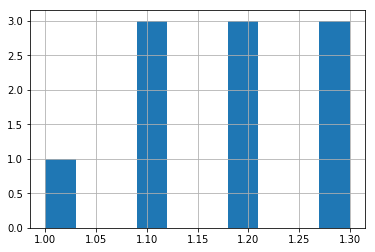

In [55]:
df_floofer.hist()

In [56]:
# Make a dataframe of ratings for dogs called pupper
df_pupper = df_master.query('pupper == "pupper"').rating

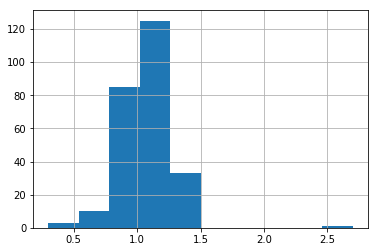

In [57]:
df_pupper.hist()

In [58]:
# Make a dataframe of ratings for dogs called puppo
df_puppo = df_master.query('puppo == "puppo"').rating

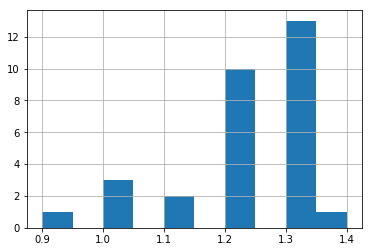

In [59]:
df_puppo.hist()

In [60]:
df_doggo.describe()

count    97.000000
mean      1.180412
std       0.155884
min       0.500000
25%       1.100000
50%       1.200000
75%       1.300000
max       1.400000
Name: rating, dtype: float64

In [61]:
df_floofer.describe()

count    10.00000
mean      1.18000
std       0.10328
min       1.00000
25%       1.10000
50%       1.20000
75%       1.27500
max       1.30000
Name: rating, dtype: float64

In [62]:
df_pupper.describe()

count    257.00000
mean       1.08716
std        0.20163
min        0.30000
25%        1.00000
50%        1.10000
75%        1.20000
max        2.70000
Name: rating, dtype: float64

In [63]:
df_puppo.describe()

count    30.000000
mean      1.213333
std       0.116658
min       0.900000
25%       1.200000
50%       1.200000
75%       1.300000
max       1.400000
Name: rating, dtype: float64